In [7]:
import datetime

apalis = {
    # really Tractor02
    "Tractor01": ["/home/tjw/Downloads/apalis24/Tractor02-gps01.csv",
                  "/home/tjw/Downloads/apalis24/Tractor02-gps02.csv"],
    
    # really Tractor03
    "Tractor02": ["/home/tjw/Downloads/apalis24/Tractor03-gps01.csv",
                  "/home/tjw/Downloads/apalis24/Tractor03-gps02.csv"],
    
    # really Tractor04
    "Tractor03": ["/home/tjw/Downloads/apalis24/Tractor04-gps01.csv",
                  "/home/tjw/Downloads/apalis24/Tractor04-gps02.csv",
                  "/home/tjw/Downloads/apalis24/Tractor04-gps03.csv"]
}

gopro = {
    "Tractor01": ["/home/tjw/Documents/gopro24/Tractor02"], # really Tractor02
    "Tractor02": ["/home/tjw/Documents/gopro24/Tractor03"], # really Tractor03
    "Tractor03": ["/home/tjw/Documents/gopro24/Tractor04"]  # really Tractor04
}

canbus = {
    "apalis1": "/home/tjw/Documents/apalis24/2024_apalis1.sql",
    "apalis2": "/home/tjw/Documents/apalis24/2024_apalis2.sql",
    "apalis3": "/home/tjw/Documents/apalis24/2024_apalis3.sql",
    "apalis4": "/home/tjw/Documents/apalis24/2024_apalis4.sql"
}

isoblue = {
    # really Tractor02
    "Tractor01": {
        "apalis1": {"start": datetime.datetime(2024,1,1),
                    "end": datetime.datetime(2024,6,17)},
        "apalis3": {"start": datetime.datetime(2024,6,17),
                    "end": datetime.datetime(2024,10,31)}
    },

    # really Tractor03
    "Tractor02": {
        "apalis2": {"start": datetime.datetime(2024,1,1),
                    "end": datetime.datetime(2024,8,22)},
        "apalis4": {"start": datetime.datetime(2024,1,1),
                    "end": datetime.datetime(2024,10,31)}
    },

    # really Tractor04
    "Tractor03": {
        "apalis3": {"start": datetime.datetime(2024,1,1),
                    "end": datetime.datetime(2024,6,17)},
        "apalis1": {"start": datetime.datetime(2024,6,17),
                    "end": datetime.datetime(2024,8,22)},
        "apalis2": {"start": datetime.datetime(2024,8,22),
                    "end": datetime.datetime(2024,10,31)}
    }
}

maintenance = [ # all the dates of data swaps
    datetime.datetime(2024, 5, 5),
    datetime.datetime(2024, 5,19),
    datetime.datetime(2024, 5,28),
    datetime.datetime(2024, 6, 5),
    datetime.datetime(2024, 6,10),
    datetime.datetime(2024, 6,17),
    datetime.datetime(2024, 6,28),
    datetime.datetime(2024, 7,17),
    datetime.datetime(2024, 7,29),
    datetime.datetime(2024, 8,22),
    datetime.datetime(2024, 9, 1),
    datetime.datetime(2024, 9, 9),
    datetime.datetime(2024, 9,26),
    datetime.datetime(2024,10,17)
]


In [8]:
def stamp(dt):
    # minute = dt.minute - (dt.minute % 10)
    # return f"{dt.date()}_{dt.hour:02}:{minute:02}"
    return f"{dt.date()}_{dt.hour:02}:{dt.minute:02}"

def unstamp(st):
    date, time = st.split("_")
    yy,mm,dd = date.split("-")
    hh,mn = time.split(":")
    #hh,mn = time, 0
    return datetime.datetime(
        year=int(yy), month=int(mm), day=int(dd),
        hour=int(hh), minute=int(mn)
    )

In [10]:
# Get line totals for DB dumps
import subprocess

line_total = {}

for db in canbus:
    line_total[db] = int(subprocess.check_output(["wc", "-l", canbus[db]]).decode().split()[0])


In [11]:
def roll_avg(frame, new):
    N = frame[1] + 1
    output = frame[0]*(1 - 1/N) + new/N
    return output, N


In [12]:
# Read Isoblue CAN data
import time
#MAGIC = 0.00125 # scaling factor for CAN bus ground speed to get (kph?)
MAGIC = 0.0025
BAR_W = 49

c_data = {}

for tractor in isoblue:
    c_data[tractor] = {"speed":{}, "stamps":[]}

    for db in isoblue[tractor]:
        stime = time.time()
        start = isoblue[tractor][db]["start"]
        end = isoblue[tractor][db]["end"]

        with open(canbus[db]) as file:
            i = 0
            for line in file:
                if "can0" in line:
                    l = line.split("\t")
                    arb = l[2]
                    if arb[2:6] == "FEF1": # vehicle ground speed PGN
                        
                        # Get datetime of line
                        timestamp = l[0].split(".")[0]
                        if "+" in timestamp:
                            timestamp = timestamp.split("+")[0]
                        dt = parser.isoparse(timestamp)
                        
                        # Check that line is within parameters of tractor
                        if dt >= start and dt < end:
                            hex_data = l[3]
                            speed = MAGIC * (256*int(hex_data[4:6], 16) + 
                                             int(hex_data[6:8], 16))
                            
                            # Save data to output
                            st = stamp(dt)
                            if st not in c_data[tractor]["speed"].keys():
                                c_data[tractor]["speed"][st] = (speed, 1)
                            else:
                                c_data[tractor]["speed"][st] = roll_avg(
                                    c_data[tractor]["speed"][st], speed
                                )
                            
                            if st not in c_data[tractor]["stamps"]:
                                c_data[tractor]["stamps"].append(st)
            
                # Print progress
                i += 1
                if i % 250_000 == 0:
                    y = time.time() - stime
                    x = i/line_total[db]
                    pct = round(BAR_W*x)
                    bar = "="*pct
                    space = " "*(BAR_W-pct)
                    print(f"[{tractor}/{db}]: |{bar}>{space}| ~{round((y/x)-y)}s remain...   ", end="\r")
        print(f"[{tractor}/{db}] Finished with {db} in {round(time.time() - stime)}s {' '*BAR_W}")
    print(f"**[{tractor}] Found a total of {len(c_data[tractor]['speed'])} speeds")


[Tractor01/apalis1] Finished with apalis1 in 173s                                                  
[Tractor01/apalis3] Finished with apalis3 in 92s                                                  
**[Tractor01] Found a total of 6267 speeds
[Tractor02/apalis2] Finished with apalis2 in 166s                                                  
[Tractor02/apalis4] Finished with apalis4 in 19s                                                  
**[Tractor02] Found a total of 1007 speeds
[Tractor03/apalis3] Finished with apalis3 in 51s                                                  
[Tractor03/apalis1] Finished with apalis1 in 132s                                                  
[Tractor03/apalis2] Finished with apalis2 in 453s                                                  
**[Tractor03] Found a total of 11693 speeds


In [ ]:
# Read Isoblue GPS data
from dateutil import parser

a_data = {}
SKIP = 5
MIN_SPEED = 2 # cutoff for ground speed needed to say they were actually working

for tractor in apalis:
    a_data[tractor] = {"datetime":[], "longlat":[], "stamps": [], "speed": {}}
    for csv in apalis[tractor]:
        with open(csv) as file:
            i = 0
            for line in file.readlines()[1:]:
                i += 1
                if i % SKIP == 0:
                    # Parse data from CSV
                    time, lat, lng = line.split(",")
                    lat = float(lat)
                    lng = float(lng.rstrip())
                    time = parser.isoparse(time)
                    
                    # Add data to dict
                    a_data[tractor]["datetime"].append(time)
                    a_data[tractor]["longlat"].append((lng, lat))
                    st = stamp(time)
                    
                    if st not in a_data[tractor]["stamps"]:
                        if c_data[tractor]["speed"][st][0] > MIN_SPEED:
                            a_data[tractor]["stamps"].append(st)
                        else:
                            pass # don't count periods without movement


In [13]:
def goproParse(jsondata):
    gps = []
    times = []
    stamps = []
    for frame in jsondata:
        time = parser.isoparse(frame["gps_time"])
        if time.year == 2024:
            times.append(time)
            stamps.append(stamp(time))
            lon = frame["cam_gps"]["lon"]
            lat = frame["cam_gps"]["lat"]
            gps.append((lon,lat))
    return (times, gps, stamps)

In [14]:
import json, os
g_data = {}
for tractor in gopro:
    g_data[tractor] = {"datetime":[], "longlat":[], "stamps":[]}
    for folder in gopro[tractor]:
        for file in os.listdir(folder):
            if "metadata" not in file:
                with open(os.path.join(folder, file)) as file:
                    times, gps, stamps = goproParse(json.load(file))
                    g_data[tractor]["longlat"] += (gps)
                    g_data[tractor]["datetime"] += times

                    for st in stamps:
                        if st not in g_data[tractor]["stamps"]:
                            g_data[tractor]["stamps"].append(st)


In [15]:
def same(x1, x2): # return intersection of two lists
    output = []
    for x in x1:
        if x in x2:
            output.append(x)
    return output

def inany(x1, x2): # return union of two lists
    output = [x for x in x1]
    for x in x2:
        if x not in output:
            output.append(x)
    return output


In [16]:
tractors = same(gopro, apalis)

print(tractors)

['Tractor01', 'Tractor02', 'Tractor03']


In [17]:
u_data = {}

for tractor in tractors:
    u_data[tractor] = {}
    u_data[tractor]["stamps"] = same(a_data[tractor]["stamps"], g_data[tractor]["stamps"])
    u_data[tractor]["longlat"] = []

    for i in range(0, len(g_data[tractor]["datetime"]), SKIP):
        if stamp(g_data[tractor]["datetime"][i]) in u_data[tractor]["stamps"]:
            u_data[tractor]["longlat"].append(g_data[tractor]["longlat"][i])


In [ ]:
import geojson
from shapely.geometry import Polygon

with open("County_Boundaries_of_Indiana_2023.geojson") as file:
    IN_COUNTIES = geojson.load(file)

counties = {}
for i in range(len(IN_COUNTIES["features"])):
    name = IN_COUNTIES["features"][i]["properties"]["name"]
    name = name.split(" County")[0]
    counties[name] = Polygon(IN_COUNTIES["features"][i]["geometry"]["coordinates"][0][0])


In [ ]:
# Copied from https://stackoverflow.com/a/70533052
import numpy as np
from matplotlib.collections import PatchCollection
from matplotlib.patches import PathPatch
from matplotlib.path import Path

def plot_polygon(ax, poly, **kwargs):
    path = Path.make_compound_path(
        Path(np.asarray(poly.exterior.coords)[:, :2]),
        *[Path(np.asarray(ring.coords)[:, :2]) for ring in poly.interiors])

    patch = PathPatch(path, **kwargs)
    collection = PatchCollection([patch], **kwargs)
    
    ax.add_collection(collection, autolim=True)
    ax.autoscale_view()
    return collection

In [ ]:
from shapely.geometry import Point

# Greedy (but still slow) County Checker
def check_county(coords, county):
    for point in coords:
        if county.contains(Point(point)):
            return True
    return False

# Greedy tractor-county checker
def tc_check(dataset, county):
    for tractor in dataset:
        if check_county(dataset[tractor]["longlat"], county):
            return True
    return False


In [ ]:
# Check which counties had which/both sources
data_counties = {}
for county in counties:
    data_counties[county] = ""
    if tc_check(u_data, counties[county]):
        data_counties[county] = "Both"
    else:
        if tc_check(a_data, counties[county]):
            data_counties[county] += "A"
        if tc_check(g_data, counties[county]):
            data_counties[county] += "G"
    
    print(f"{county}: {data_counties[county]}")


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as pch

fig, ax = plt.subplots()
for county in counties:
    if data_counties[county] == "Both":
        plot_polygon(ax, counties[county], facecolor="goldenrod", edgecolor="black")
    elif data_counties[county] in ["A", "G", "AG"]:
        plot_polygon(ax, counties[county], facecolor="silver", edgecolor="black")
    else:
        plot_polygon(ax, counties[county], facecolor="white", edgecolor="black")

# Create legend
gold = pch.Patch(color="goldenrod", label="Full Record")
silver = pch.Patch(color="silver", label="Partial Record")
fig.legend([gold, silver], ["Monitored", "Partial Data"], loc="upper center", ncol=2)

ax.set_xticklabels("")
ax.set_yticklabels("")
fig.set_size_inches(6,6)
ax.set_aspect(1.0)


In [ ]:
x= {}
fig = plt.figure()

i = 0
for tractor in tractors:
    # IsoBlue Data
    x[tractor] = [unstamp(date) for date in a_data[tractor]["stamps"]]
    blue = plt.scatter(x[tractor], [i-0.2 for _ in x[tractor]], color="cornflowerblue", linewidths=5, label="Telematics")

    # GoPro Data
    x[tractor] = [unstamp(date) for date in g_data[tractor]["stamps"]]
    grey = plt.scatter(x[tractor], [i for _ in x[tractor]], color="grey", linewidths=5, label="Camera")

    # Both data
    x[tractor] = [unstamp(date) for date in u_data[tractor]["stamps"]]
    gold = plt.scatter(x[tractor], [i+0.2 for _ in x[tractor]], color="goldenrod", linewidths=5, label="Both")

    i += 1

bot, top = plt.ylim()
red = plt.vlines(maintenance, ymin=bot, ymax=top, colors="tab:red", linestyles="dotted", zorder=0)

plt.legend([blue, grey, gold, red], ["Telematics", "Camera", "Simultaneous", "Maintenance\nDates"], bbox_to_anchor=(1,1))
inum = [i for i in range(len(x))]
plt.yticks(ticks=inum, labels=[f"Tractor{i+1:02}" for i in inum])
fig.set_size_inches(9,5)
plt.xlim(datetime.datetime(2024, 5, 1), datetime.datetime(2024, 10, 31))
plt.show()

In [97]:
minutes = {
    "Telematics-Only": 0,
    "Camera-Only": 0,
    "Both": 0
}
nm = 0

for tractor in tractors:
    for st in inany(a_data[tractor]["stamps"], g_data[tractor]["stamps"]):
        if st in u_data[tractor]["stamps"]:
            if st not in c_data[tractor]["speed"]:
                minutes["Both"] += 1
            elif c_data[tractor]["speed"][st][0] > MIN_SPEED:
                minutes["Both"] += 1
            else:
                nm += 1
        elif st in a_data[tractor]["stamps"]:
            if st not in c_data[tractor]["speed"]:
                minutes["Telematics-Only"] += 1
            elif c_data[tractor]["speed"][st][0] > MIN_SPEED:
                minutes["Telematics-Only"] += 1
            else:
                nm += 1
        else:
            if st not in c_data[tractor]["speed"]:
                minutes["Camera-Only"] += 1
            elif c_data[tractor]["speed"][st][0] > MIN_SPEED:
                minutes["Camera-Only"] += 1
            else:
                nm += 1
print(f"CAN ground speed prevented counting {round(nm/60, 1)} hours of data")
minutes


CAN ground speed prevented counting 58.6 hours of data


{'Telematics-Only': 132145, 'Camera-Only': 42071, 'Both': 8644}

In [104]:
hours24 = {
    "Telematics-Only": minutes["Telematics-Only"]/60,
    "Camera-Only": minutes["Camera-Only"]/60,
    "Simultaneous": minutes["Both"]/60
}

# from unify_gps.ipynb:
hours23 = {'Telematics-Only': 1425.55,
 'Camera-Only': 64.58333333333333,
 'Simultaneous': 27.833333333333332}


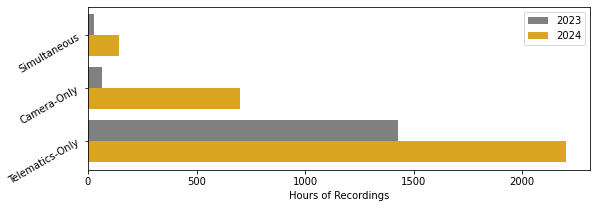

In [105]:
import matplotlib.pyplot as plt
import numpy as np

bar_width = 0.4
xx = np.arange(len(hours23))
plt.figure(figsize=(9,3))
plt.barh(xx, [hours23[i] for i in hours23], bar_width, label="2023", color="grey")
plt.barh(xx-bar_width, [hours24[i] for i in hours24], bar_width, label="2024", color="goldenrod")

plt.legend()
plt.xlabel("Hours of Recordings")
plt.yticks(xx-(bar_width/2), labels=list(hours23.keys()), rotation=30)
plt.show()


In [106]:
total24 = sum(hours24.values())
total23 = sum(hours23.values())


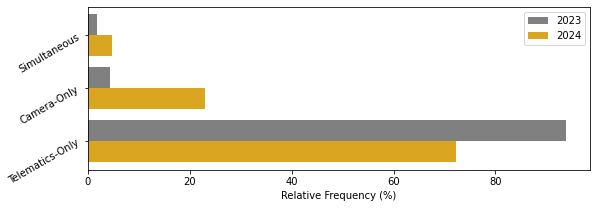

In [107]:
bar_width = 0.4
xx = np.arange(len(hours23))
plt.figure(figsize=(9,3))
plt.barh(xx, [100*hours23[i]/total23 for i in hours23], bar_width, label="2023", color="grey")
plt.barh(xx-bar_width, [100*hours24[i]/total24 for i in hours24], bar_width, label="2024", color="goldenrod")

plt.legend()
plt.xlabel("Relative Frequency (%)")
plt.yticks(xx-(bar_width/2), labels=list(hours23.keys()), rotation=30)
plt.show()


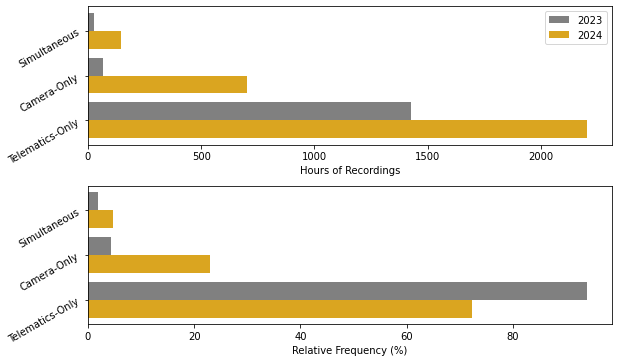

In [108]:
fig, ax = plt.subplots(2,1)
fig.set_size_inches(8,5)
fig.tight_layout(h_pad=2.0)

bar_width = 0.4
xx = np.arange(len(hours23))
ax[0].barh(xx, [hours23[i] for i in hours23], bar_width, label="2023", color="grey")
ax[0].barh(xx-bar_width, [hours24[i] for i in hours24], bar_width, label="2024", color="goldenrod")
ax[0].legend()
ax[0].set_xlabel("Hours of Recordings")
ax[0].set_yticks(xx-(bar_width/2), labels=list(hours23.keys()), rotation=30)


ax[1].barh(xx, [100*hours23[i]/total23 for i in hours23], bar_width, label="2023", color="grey")
ax[1].barh(xx-bar_width, [100*hours24[i]/total24 for i in hours24], bar_width, label="2024", color="goldenrod")
# ax[1].legend()
ax[1].set_xlabel("Relative Frequency (%)")
ax[1].set_yticks(xx-(bar_width/2), labels=list(hours23.keys()), rotation=30)
plt.show()

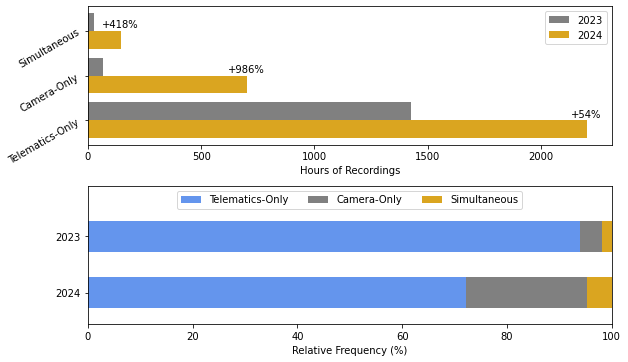

In [109]:
fig, ax = plt.subplots(2,1)
fig.set_size_inches(8,5)
fig.tight_layout(h_pad=2.0)

bar_width = 0.4
xx = np.arange(len(hours23))
ax[0].barh(xx, [hours23[i] for i in hours23], bar_width, label="2023", color="grey")
ax[0].barh(xx-bar_width, [hours24[i] for i in hours24], bar_width, label="2024", color="goldenrod")
ax[0].legend()
ax[0].set_xlabel("Hours of Recordings")
ax[0].set_yticks(xx-(bar_width/2), labels=list(hours23.keys()), rotation=30)

b0 = 0
for i in hours24:
    ax[0].annotate(f"+{round(100*((hours24[i]/hours23[i])-1))}%",
                   (hours24[i], xx[b0]-bar_width/3), ha="center")
    b0 += 1

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

cc = {
    'Telematics-Only': "cornflowerblue",
    'Camera-Only': "grey",
    'Simultaneous': "goldenrod"
}
co = {}

b1, b0 = 0, 0
H = 1.8*bar_width
for i in hours23:
    co[i] = ax[1].barh(H, 100*hours23[i]/total23, bar_width, left=b1, color=cc[i])
    ax[1].barh(0, 100*hours24[i]/total24, bar_width, left=b0, color=cc[i])
    b1 += 100*hours23[i]/total23
    b0 += 100*hours24[i]/total24
ax[1].legend(co.values(), co.keys(), ncols=3, loc="upper center")
ax[1].set_xlabel("Relative Frequency (%)")
ax[1].set_xlim(0,100)
ax[1].set_yticks([H,0], labels=["2023", "2024"])
ax[1].set_ylim(0-bar_width, 1.9*H)
plt.show()